In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

pd.set_option("display.max.rows",None)
pd.set_option("display.max.columns",None)

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier


from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from imblearn.over_sampling import SMOTE

Two datasets are provided - training and test datasets

In [2]:
df_train = pd.read_csv('/Users/shuvayandasgupt/Downloads/train.csv')
df_test  = pd.read_csv('/Users/shuvayandasgupt/Downloads/test.csv')

In [3]:
print("Data info of features of Training Data is:")
print(df_train.info())
print("\n"+"-"*100)
print("\nData info of features of Testing Data is:")
print(df_test.info())

Data info of features of Training Data is:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None

---------------------------------------------------------------------------------------------

# Data Visualization 

<Figure size 1500x500 with 0 Axes>

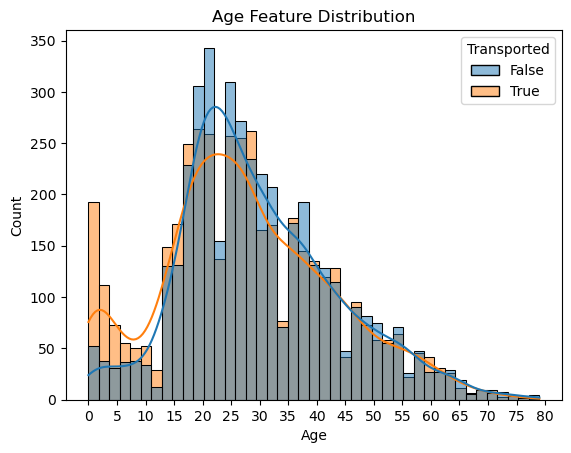

<Figure size 1500x500 with 0 Axes>

In [4]:
sns.histplot(x="Age",hue="Transported",data=df_train,kde=True)
plt.xticks(list(range(0,85,5)))
plt.title("Age Feature Distribution");
plt.figure(figsize=(15,5))

Age 0-18 have higher chances of getting transported
Age 20-40 has much lower chances of getting transported
Age above 32 seems to be equally transported when compared to not transported passengers.

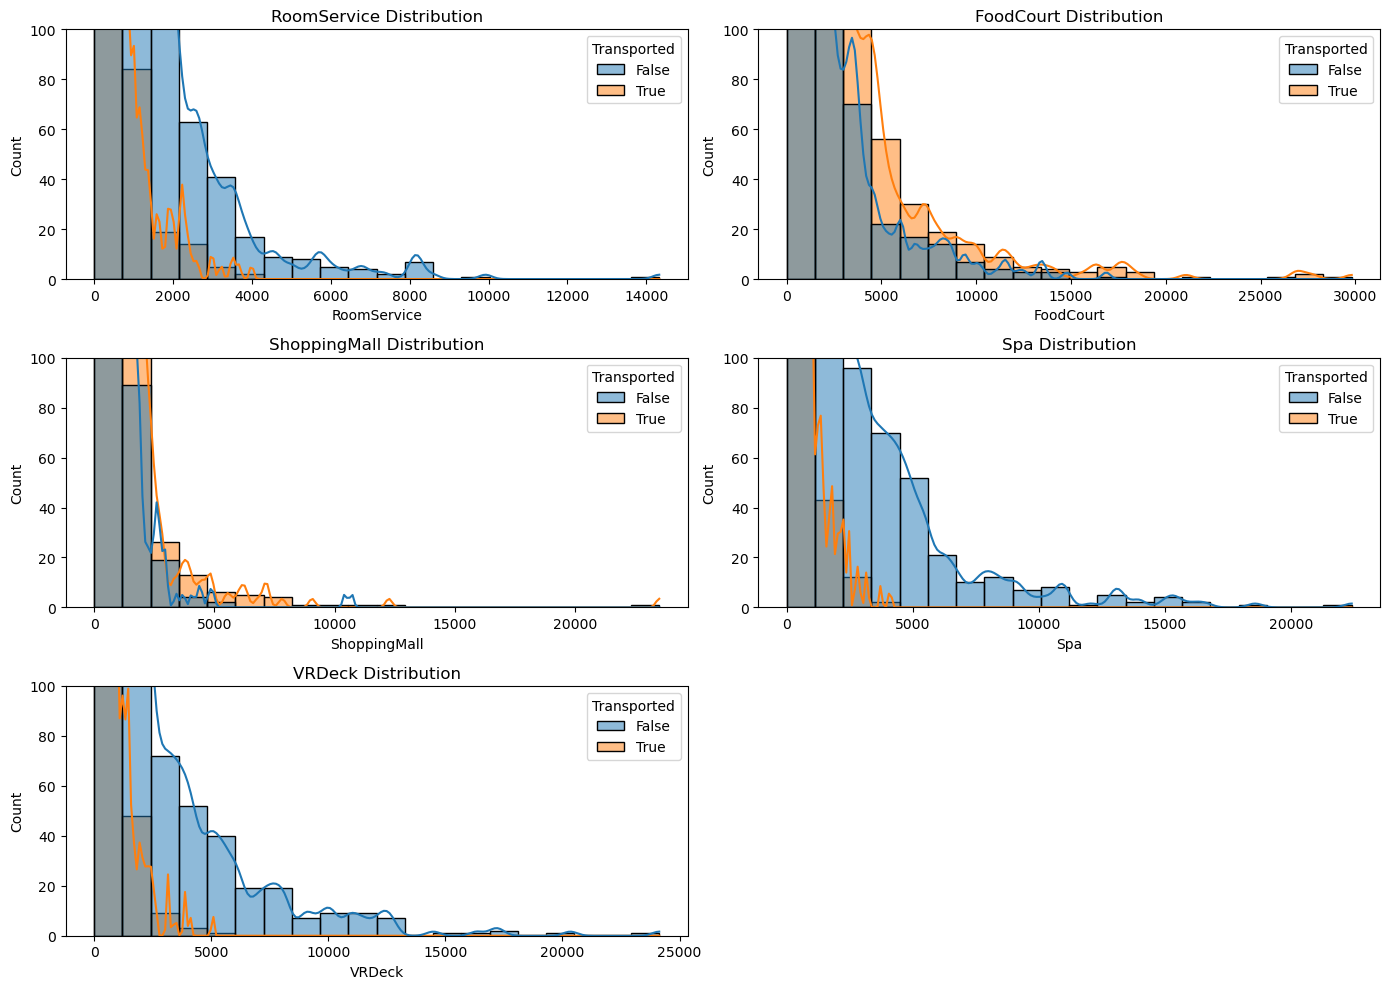

In [5]:
exp_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

plt.figure(figsize=(14,10))
for idx,column in enumerate(exp_cols):
    plt.subplot(3,2,idx+1)
    sns.histplot(x=column, hue="Transported", data=df_train,bins=20,kde=True)
    plt.title(f"{column} Distribution")
    plt.ylim(0,100)
    plt.tight_layout()

Most people did not spend on luxuries
People who has spend low are mostly transported
Since, all expenditure features are having right-skewed distribution. So before Model Building we will transform these features to normal distribution using log-transformation.

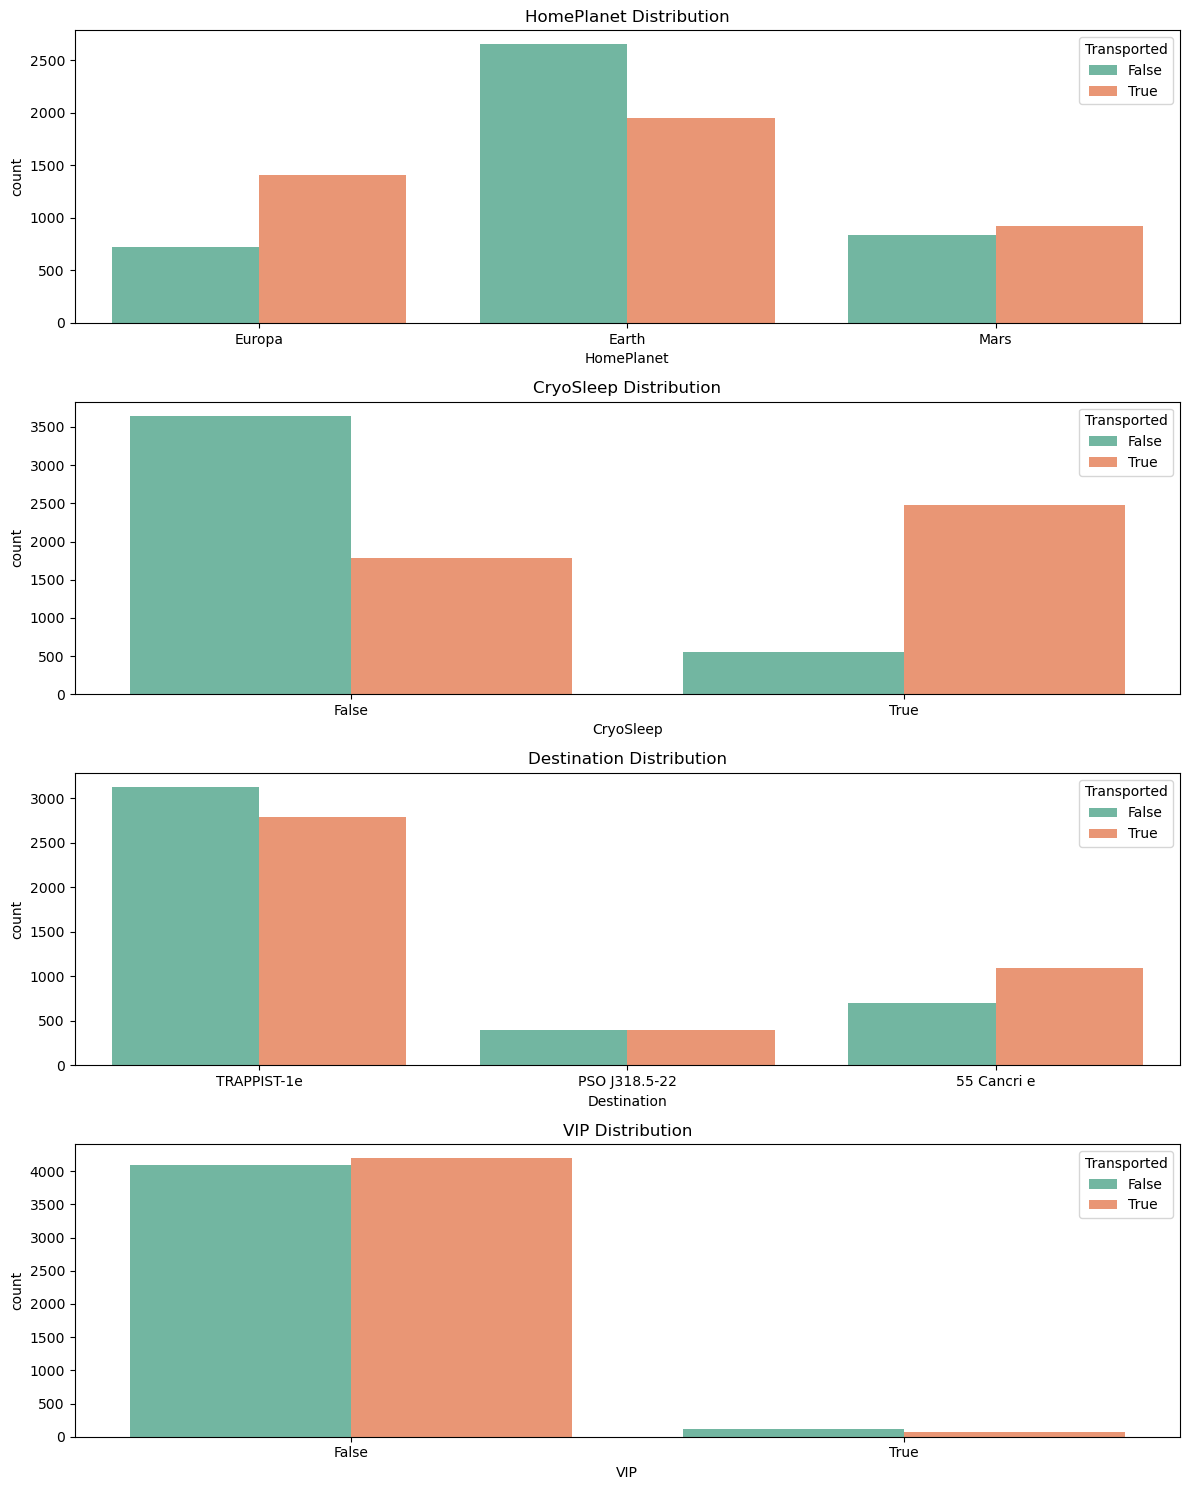

In [6]:
cat_cols = ["HomePlanet","CryoSleep","Destination","VIP"]
df_train['Transported'] = df_train['Transported'].astype(str)
plt.figure(figsize=(12,15))
df_train['Transported'] = df_train['Transported'].astype(str)

for idx,column in enumerate(cat_cols):
    plt.subplot(4,1,idx+1)
    sns.countplot(x=column, hue="Transported", data=df_train, palette="Set2")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

VIP feature can cause overfitting and it is dominating in huge margin.
Better to drop that feature
In Cryosleep, there is higher chances of getting transported
Most of the passenger are from Earth

# Feature Engineering

In [7]:
df_train["PassengerId"].head()

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
Name: PassengerId, dtype: object

In [8]:
def passengerid_new_features(df):

    #Splitting Group and Member values from "PassengerId" column.
    df["Group"] = df["PassengerId"].apply(lambda x: x.split("_")[0])
    df["Member"] =df["PassengerId"].apply(lambda x: x.split("_")[1])

    #Grouping the "Group" feature with respect to "member" feature to check which group is travelling with how many members
    x = df.groupby("Group")["Member"].count().sort_values()

    #Creating a set of group values which are travelling with more than 1 members.
    y = set(x[x>1].index)

    #Creating a new feature "Solo" which will indicate whether the person is travelling solo or not.
    df["Travelling_Solo"] = df["Group"].apply(lambda x: x not in y)

    #Creating a new feature "Group_size" which will indicate each group number of members.
    df["Group_Size"]=0
    for i in x.items():
        df.loc[df["Group"]==i[0],"Group_Size"]=i[1]


In [9]:
passengerid_new_features(df_train)
passengerid_new_features(df_test)

Group and member no long needed

In [10]:
df_train.drop(columns=["Group","Member"],inplace=True)
df_test.drop(columns=["Group","Member"],inplace=True)

<Figure size 1200x2000 with 0 Axes>

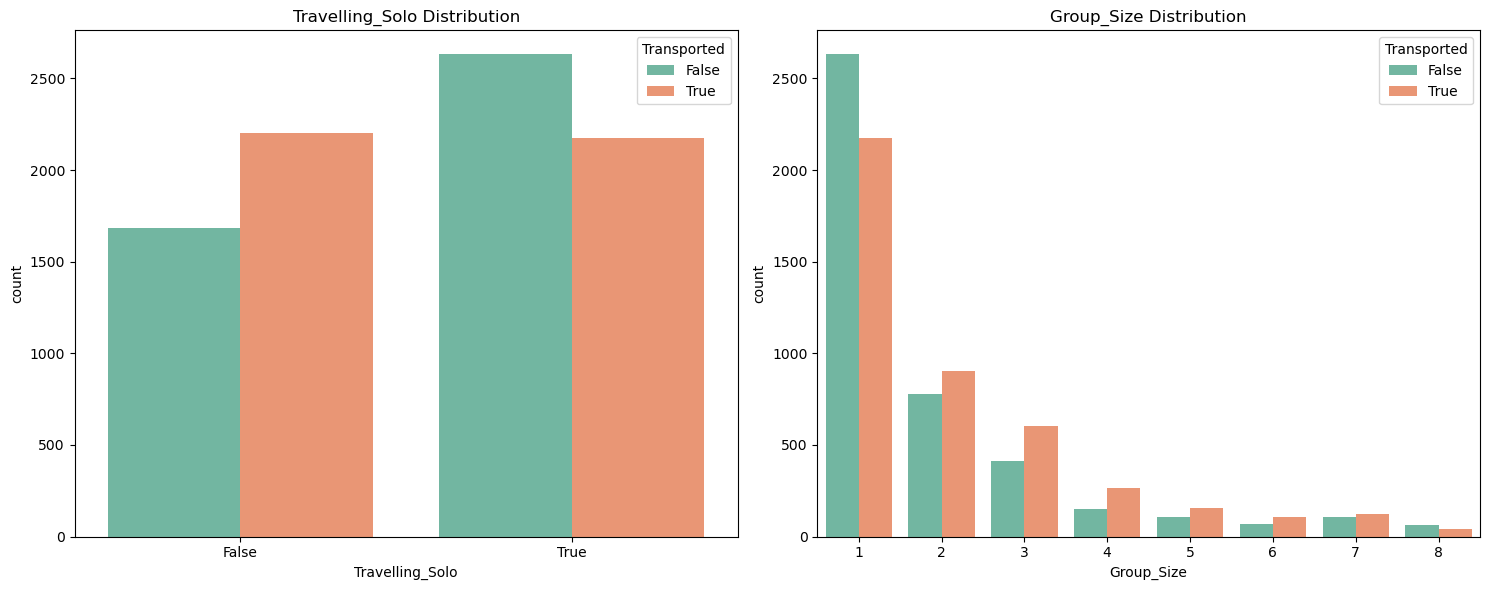

In [11]:
new_cat_cols = ["Travelling_Solo","Group_Size"]
df_train['Transported'] = df_train['Transported'].astype(str)
plt.figure(figsize=(12,20))
plt.figure(figsize=(15,6))
for idx,column in enumerate(new_cat_cols):
    plt.subplot(1,2,idx+1)
    sns.countplot(x=column, hue="Transported", data=df_train, palette="Set2")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

Travelling in groups have lower chances of getting transported
Most people are travelling solo

In [12]:
def cabin_new_feature(df):
    df["Cabin"].fillna("np.nan/np.nan/np.nan",inplace=True)  #In this way we can split NaN values into all three categories

    df["Cabin_Deck"] = df["Cabin"].apply(lambda x: x.split("/")[0])
    df["Cabin_Number"]  = df["Cabin"].apply(lambda x: x.split("/")[1])
    df["Cabin_Side"] = df["Cabin"].apply(lambda x: x.split("/")[2])

    #Replacing string nan values to numpy nan values..
    cols = ["Cabin_Deck","Cabin_Number","Cabin_Side"]
    df[cols]=df[cols].replace("np.nan",np.nan)

    #Filling Missing Values in new features created.
    df["Cabin_Deck"].fillna(df["Cabin_Deck"].mode()[0],inplace=True)
    df["Cabin_Side"].fillna(df["Cabin_Side"].mode()[0],inplace=True)
    df["Cabin_Number"].fillna(df["Cabin_Number"].median(),inplace=True)

In [13]:
cabin_new_feature(df_train)
cabin_new_feature(df_test)

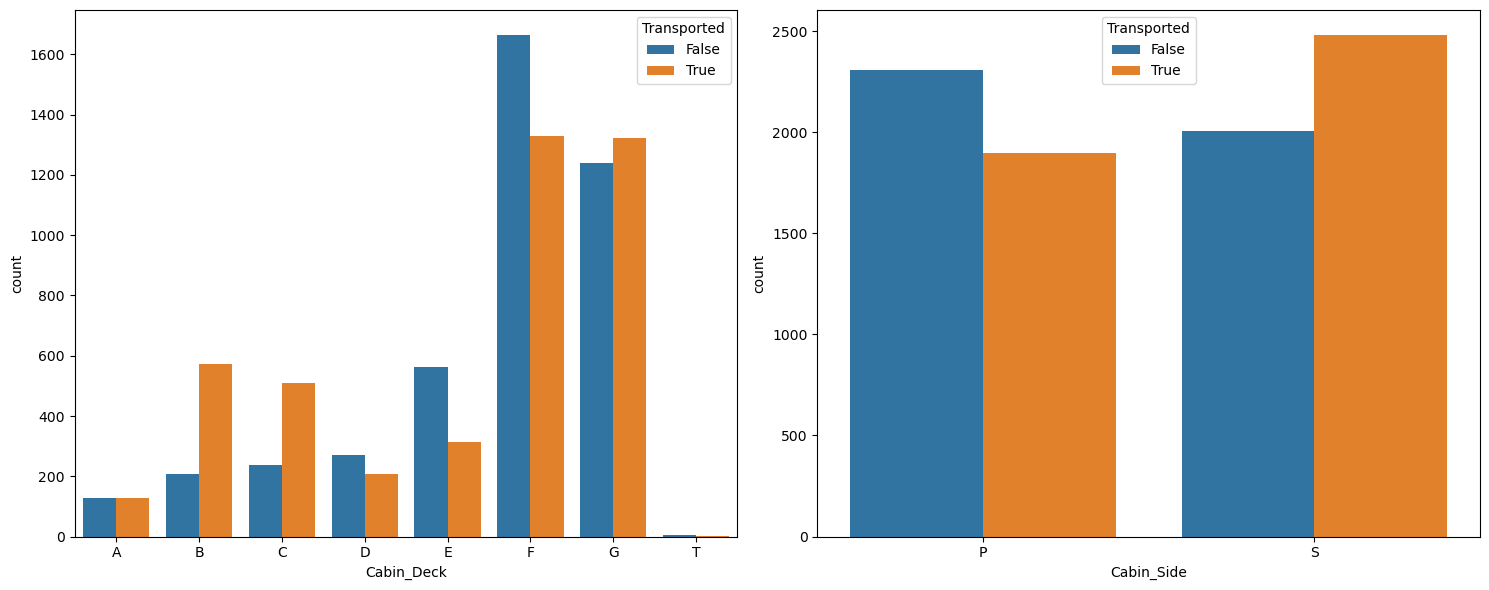

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='Cabin_Deck', hue = 'Transported', data=df_train, order =["A","B","C","D","E","F","G","T"])
plt.subplot(1,2,2)
sns.countplot(x="Cabin_Side", hue="Transported", data=df_train)
plt.tight_layout()

Passengers from Cabin S are more transported
F and G has higher number of passengers
B and C cabin deck have very high possibility of transported

In [15]:
df_train["Cabin_Number"]=df_train["Cabin_Number"].astype(int)
df_test["Cabin_Number"]=df_test["Cabin_Number"].astype(int)

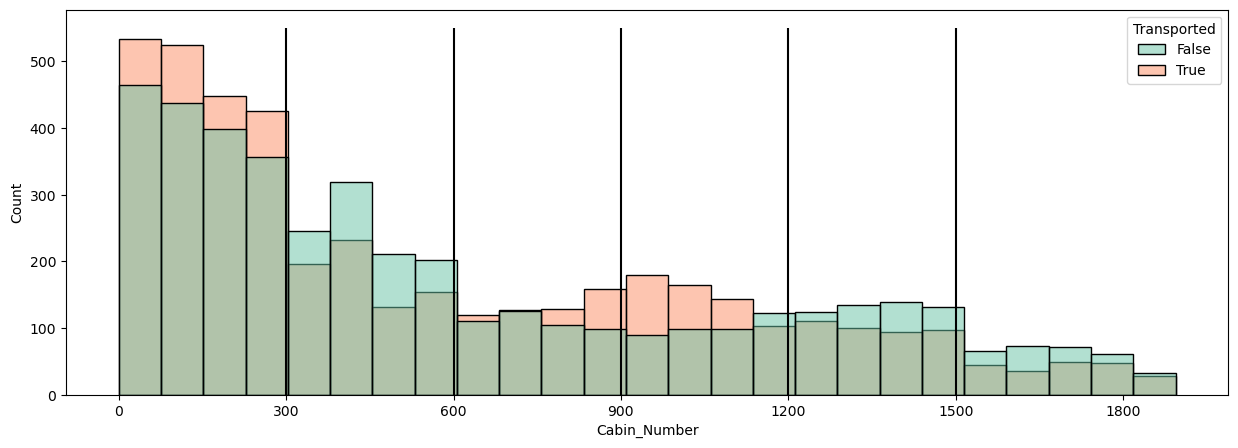

In [16]:
plt.figure(figsize=(15,5))
sns.histplot(x='Cabin_Number',hue='Transported', data=df_train, palette= "Set2")
plt.xticks(list(range(0,1900,300)))
plt.vlines(300,ymin=0,ymax=550,color="black")
plt.vlines(600,ymin=0,ymax=550,color="black")
plt.vlines(900,ymin=0,ymax=550,color="black")
plt.vlines(1200,ymin=0,ymax=550,color="black")
plt.vlines(1500,ymin=0,ymax=550,color="black")

In [17]:
def cabin_regions(df):
    df["Cabin_Region1"] = (df["Cabin_Number"]<300)
    df["Cabin_Region2"] = (df["Cabin_Number"]>=300) & (df["Cabin_Number"]<600)
    df["Cabin_Region3"] = (df["Cabin_Number"]>=600) & (df["Cabin_Number"]<900)
    df["Cabin_Region4"] = (df["Cabin_Number"]>=900) & (df["Cabin_Number"]<1200)
    df["Cabin_Region5"] = (df["Cabin_Number"]>=1200) & (df["Cabin_Number"]<1500)
    df["Cabin_Region6"] = (df["Cabin_Number"]>=1500)

In [18]:
cabin_regions(df_train)
cabin_regions(df_test)

#No more use of cabin number

In [19]:
df_train.drop(columns=["Cabin_Number"],inplace=True)
df_test.drop(columns=["Cabin_Number"],inplace=True)

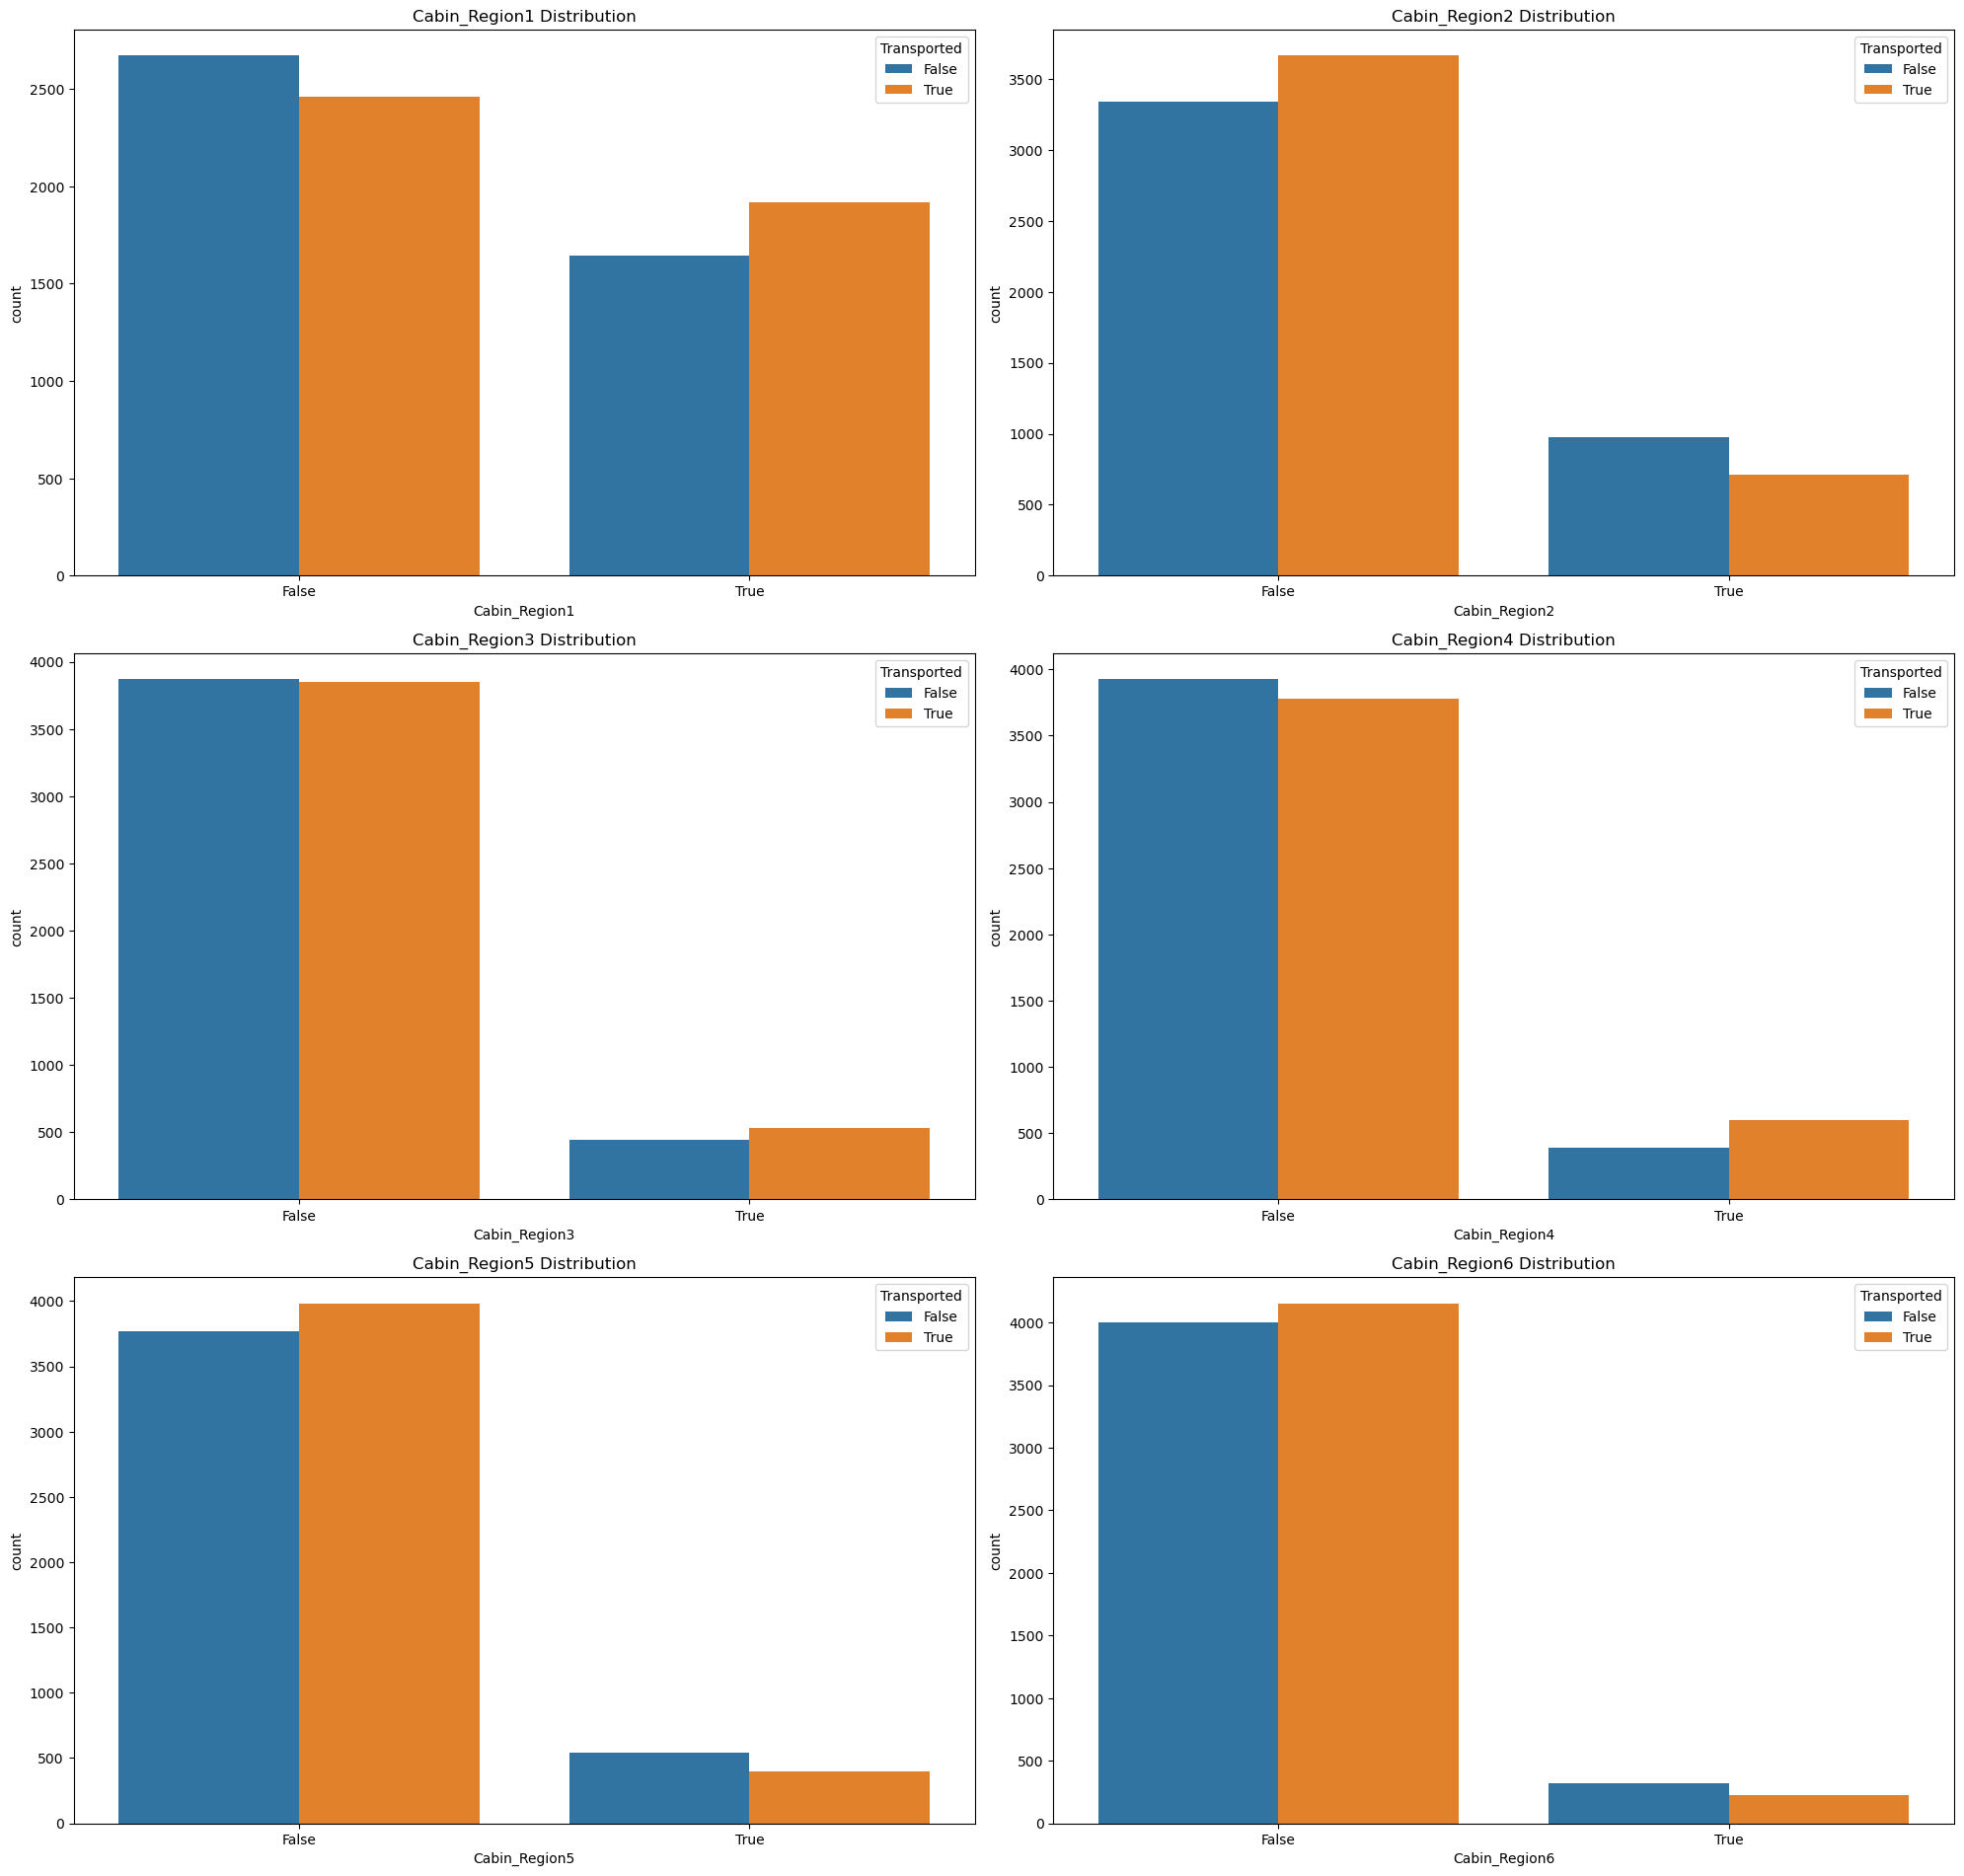

In [20]:
cols = ["Cabin_Region1","Cabin_Region2","Cabin_Region3","Cabin_Region4","Cabin_Region5","Cabin_Region6"]

plt.figure(figsize=(20,25))
for idx,value in enumerate(cols):
    plt.subplot(4,2,idx+1)
    sns.countplot(x=value, hue="Transported", data=df_train)
    plt.title(f"{value} Distribution")
    plt.tight_layout()

Lower region number higher are the chances of getting transported

In [21]:
def age_group(df):
    age_group  = []
    for i in df["Age"]:
        if i<=12:
            age_group.append("Age_0-12")
        elif (i>12 and i<=18):
            age_group.append("Age_0-18")
        elif (i>18 and i<=25):
            age_group.append("Age_19-25")
        elif (i>25 and i<=32):
            age_group.append("Age_26-32")
        elif (i>32 and i<=50):
            age_group.append("Age_33_50")
        elif (i>50):
            age_group.append("age_50+")
        else:
            age_group.append(np.nan)

    df["Age Group"] = age_group

In [22]:
age_group(df_train)
age_group(df_test)

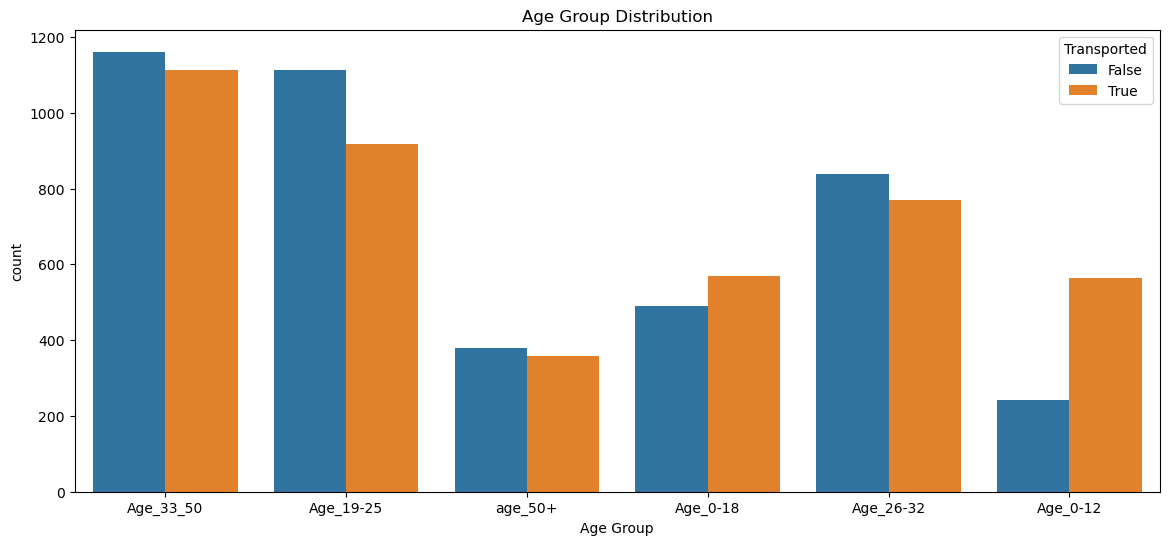

In [23]:
plt.figure(figsize=(14,6))
sns.countplot(x="Age Group",hue="Transported", data=df_train)
plt.title("Age Group Distribution");

Age 30-50 is higher in number in the ship
Age 0-18 have higher chance of getting transported

In [24]:
df_train[["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]].head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,549.0,44.0
2,43.0,3576.0,0.0,6715.0,49.0
3,0.0,1283.0,371.0,3329.0,193.0
4,303.0,70.0,151.0,565.0,2.0


In [25]:
exp_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

def new_exp_features(df):
    df["Total Expenditure"] = df[exp_cols].sum(axis=1)
    df["No Spending"] = (df["Total Expenditure"]==0)

In [26]:
new_exp_features(df_train)
new_exp_features(df_test)

Text(0.5, 1.0, 'Total expenditure histogram')

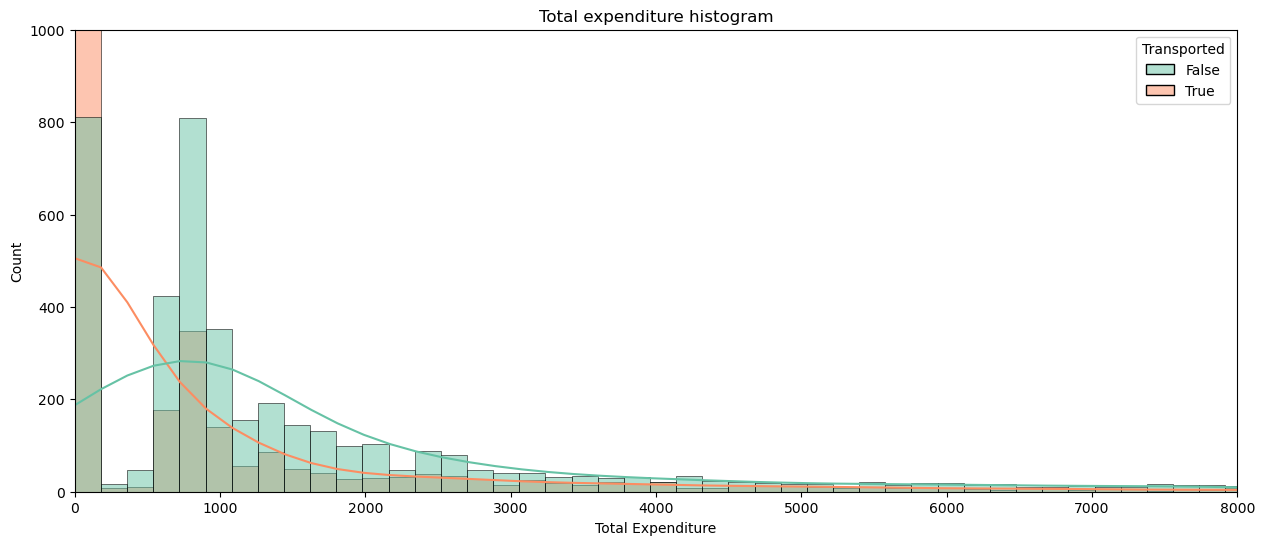

In [27]:
plt.figure(figsize=(15,6))
sns.histplot(x="Total Expenditure", hue="Transported", data=df_train, kde=True, palette="Set2",bins=200)
plt.xlim(0,8000)
plt.ylim(0,1000)
plt.title("Total expenditure histogram")

#It signifies people who have spent less or zero are mostly transported here shwoing by orange bar

In [28]:
mean = round(df_train["Total Expenditure"].mean())
median = df_train["Total Expenditure"].median()
print("Mean of total expenditure -",mean)
print("Median of total expenditure-",median)

Mean of total expenditure - 1441
Median of total expenditure- 716.0


Dividing the total expenditure into four categories namely zero, 0-716, 716-1441 and above 1441

In [29]:
def expense_category(df):
    expense =[]
    for i in df["Total Expenditure"]:
        if i ==0:
            expense.append("Zero Expense")
        elif (i>0 and i<=716):
            expense.append("Low Expense")
        elif (i>716 and i<=1441):
            expense.append("Medium Expense")
        elif i>1441:
            expense.append("High Expense")
    df["Expenditure Category"] = expense

In [30]:
expense_category(df_train)
expense_category(df_test)

<Axes: xlabel='No Spending', ylabel='count'>

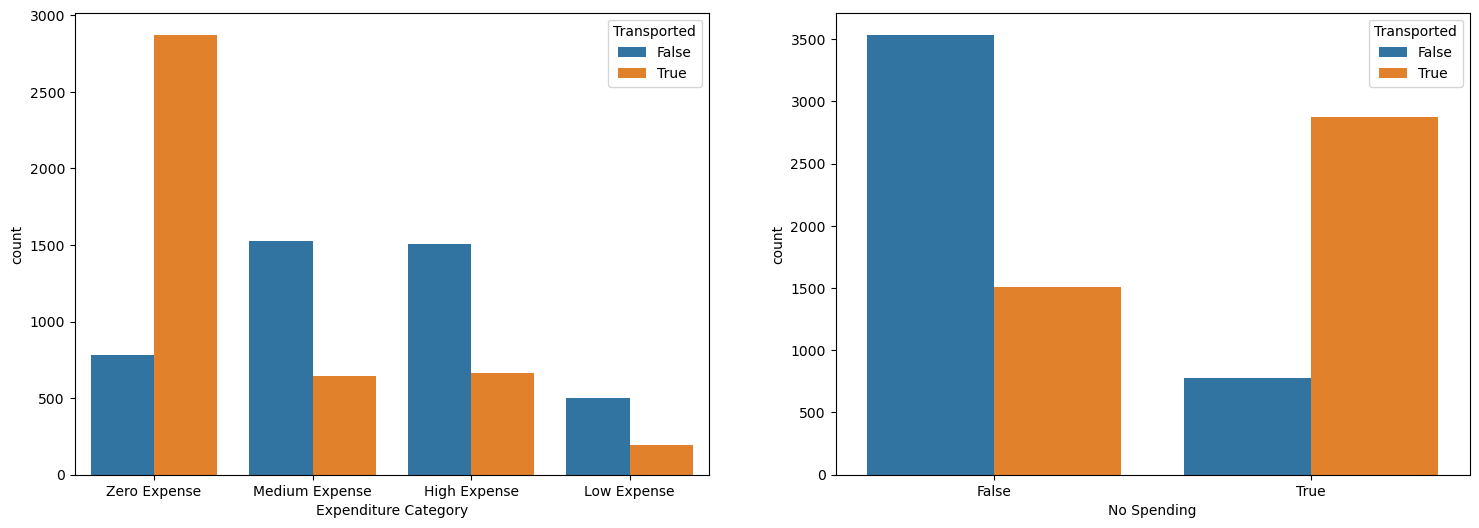

In [31]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.countplot(x='Expenditure Category',hue = 'Transported', data = df_train)
plt.subplot(1,2,2)
sns.countplot(x='No Spending',hue = 'Transported', data = df_train)


It is clearly shwoing that people who have zero expenses are more likely to get transported

# Data Pre-processing

In [32]:
df_train.isnull().sum()

PassengerId               0
HomePlanet              201
CryoSleep               217
Cabin                     0
Destination             182
Age                     179
VIP                     203
RoomService             181
FoodCourt               183
ShoppingMall            208
Spa                     183
VRDeck                  188
Name                    200
Transported               0
Travelling_Solo           0
Group_Size                0
Cabin_Deck                0
Cabin_Side                0
Cabin_Region1             0
Cabin_Region2             0
Cabin_Region3             0
Cabin_Region4             0
Cabin_Region5             0
Cabin_Region6             0
Age Group               179
Total Expenditure         0
No Spending               0
Expenditure Category      0
dtype: int64

In [33]:
df_test.isnull().sum()

PassengerId               0
HomePlanet               87
CryoSleep                93
Cabin                     0
Destination              92
Age                      91
VIP                      93
RoomService              82
FoodCourt               106
ShoppingMall             98
Spa                     101
VRDeck                   80
Name                     94
Travelling_Solo           0
Group_Size                0
Cabin_Deck                0
Cabin_Side                0
Cabin_Region1             0
Cabin_Region2             0
Cabin_Region3             0
Cabin_Region4             0
Cabin_Region5             0
Cabin_Region6             0
Age Group                91
Total Expenditure         0
No Spending               0
Expenditure Category      0
dtype: int64

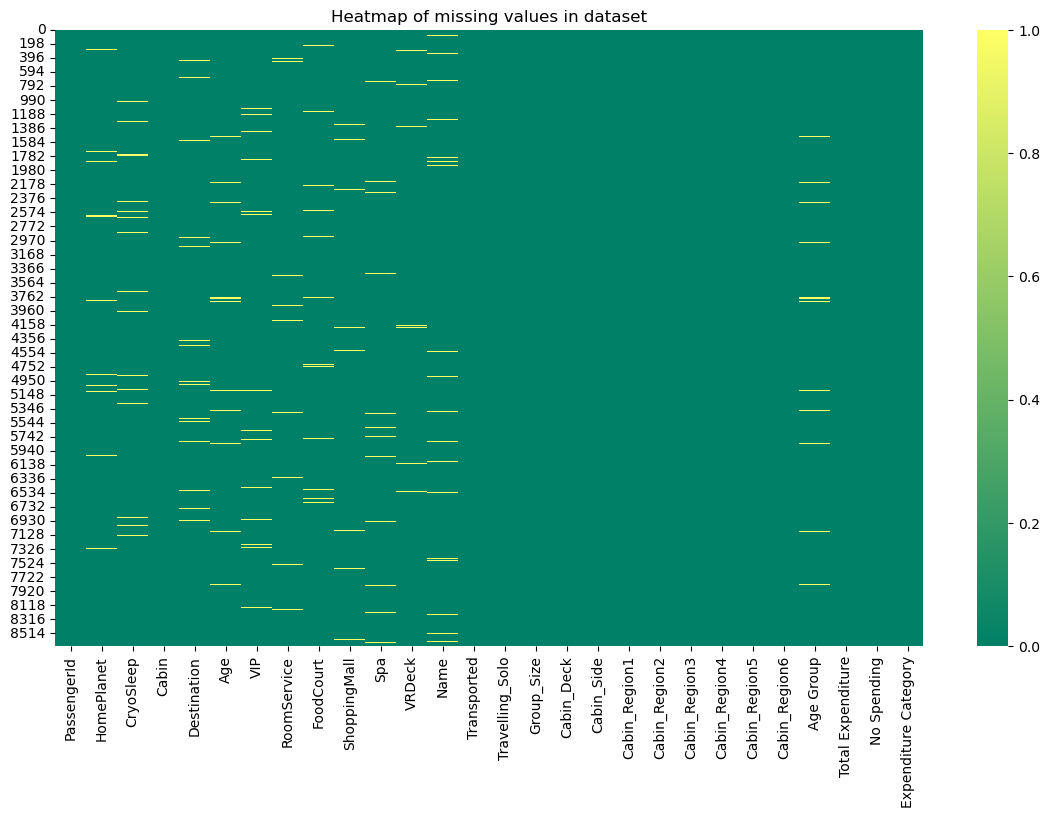

In [34]:
plt.figure(figsize=(14,8))
sns.heatmap(df_train.isnull(),cmap="summer")
plt.title("Heatmap of missing values in dataset")
plt.show()

In [35]:
#Creating a list of categorical and numerical fields

cat_cols = df_train.select_dtypes(include=["object","bool"]).columns.tolist()
cat_cols.remove("Transported")
num_cols = df_train.select_dtypes(include=["float","int"]).columns.tolist()

In [36]:
print("Categorical variable-",cat_cols)
print("---"*35)
print("Independent variables-",num_cols)

Categorical variable- ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name', 'Travelling_Solo', 'Cabin_Deck', 'Cabin_Side', 'Cabin_Region1', 'Cabin_Region2', 'Cabin_Region3', 'Cabin_Region4', 'Cabin_Region5', 'Cabin_Region6', 'Age Group', 'No Spending', 'Expenditure Category']
---------------------------------------------------------------------------------------------------------
Independent variables- ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Group_Size', 'Total Expenditure']


In [37]:
#Using Imputer library to introduce missing values

from sklearn.impute import SimpleImputer
imputer1 = SimpleImputer(strategy="most_frequent")     ##To fill Categorical Features.
imputer2 = SimpleImputer(strategy="median")            ##To fill numeircal features.

In [38]:
def filling_missing(df):
    df[cat_cols] = imputer1.fit_transform(df[cat_cols])
    df[num_cols] = imputer2.fit_transform(df[num_cols])

In [39]:
filling_missing(df_train)
filling_missing(df_test)

In [40]:
#Checking for missing data-
print("Missing values in training data is: ",df_train.isnull().sum().sum())
print("Missing values in testing data is: ",df_test.isnull().sum().sum())

Missing values in training data is:  0
Missing values in testing data is:  0


In [41]:
#Checking for duplicate data-
print("Duplicate values in training data is: ",df_train.duplicated().sum())
print("Duplicate values in testing data is: ",df_train.duplicated().sum())

Duplicate values in training data is:  0
Duplicate values in testing data is:  0


In [42]:
print("Cardinality of features in categorical data is: ")
print(df_train.select_dtypes(include=["object"]).nunique())
print("\n","-"*50)
print("\nCardinality of features in categorical data is: ")
print(df_test.select_dtypes(include=["object"]).nunique())

Cardinality of features in categorical data is: 
PassengerId             8693
HomePlanet                 3
CryoSleep                  2
Cabin                   6561
Destination                3
VIP                        2
Name                    8473
Transported                2
Travelling_Solo            2
Cabin_Deck                 8
Cabin_Side                 2
Cabin_Region1              2
Cabin_Region2              2
Cabin_Region3              2
Cabin_Region4              2
Cabin_Region5              2
Cabin_Region6              2
Age Group                  6
No Spending                2
Expenditure Category       4
dtype: int64

 --------------------------------------------------

Cardinality of features in categorical data is: 
PassengerId             4277
HomePlanet                 3
CryoSleep                  2
Cabin                   3266
Destination                3
VIP                        2
Name                    4176
Travelling_Solo            2
Cabin_Deck             

Need to drop 3 categories PassengerID,Cabin,Name as there is no use

In [43]:
#PassnegerID of test data is needed for submission 
pass_id = df_test[["PassengerId"]]

In [44]:
cols = ["PassengerId", "Cabin","Name"]

df_train.drop(columns=cols,inplace = True)
df_test.drop(columns=cols,inplace = True)

In [45]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8693.0,28.790291,14.341404,0.0,20.0,27.0,37.0,79.0
RoomService,8693.0,220.009318,660.519050,0.0,0.0,0.0,41.0,14327.0
FoodCourt,8693.0,448.434027,1595.790627,0.0,0.0,0.0,61.0,29813.0
ShoppingMall,8693.0,169.572300,598.007164,0.0,0.0,0.0,22.0,23492.0
Spa,8693.0,304.588865,1125.562559,0.0,0.0,0.0,53.0,22408.0
VRDeck,8693.0,298.261820,1134.126417,0.0,0.0,0.0,40.0,24133.0
Group_Size,8693.0,2.035546,1.596347,1.0,1.0,1.0,3.0,8.0
Total Expenditure,8693.0,1440.866329,2803.045694,0.0,0.0,716.0,1441.0,35987.0


In [46]:
#50% of the data in expenses section is zero and hence data has lots of outliers
cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck","Total Expenditure"]

for i in cols:
    df_train[i]=np.log(1+df_train[i])
    df_test[i]=np.log(1+df_test[i])

/var/folders/_6/7j451jv94xg3n62jxq5kfzqc0000gn/T/ipykernel_7930/3734596873.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[i],color="green")
/var/folders/_6/7j451jv94xg3n62jxq5kfzqc0000gn/T/ipykernel_7930/3734596873.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[i],col

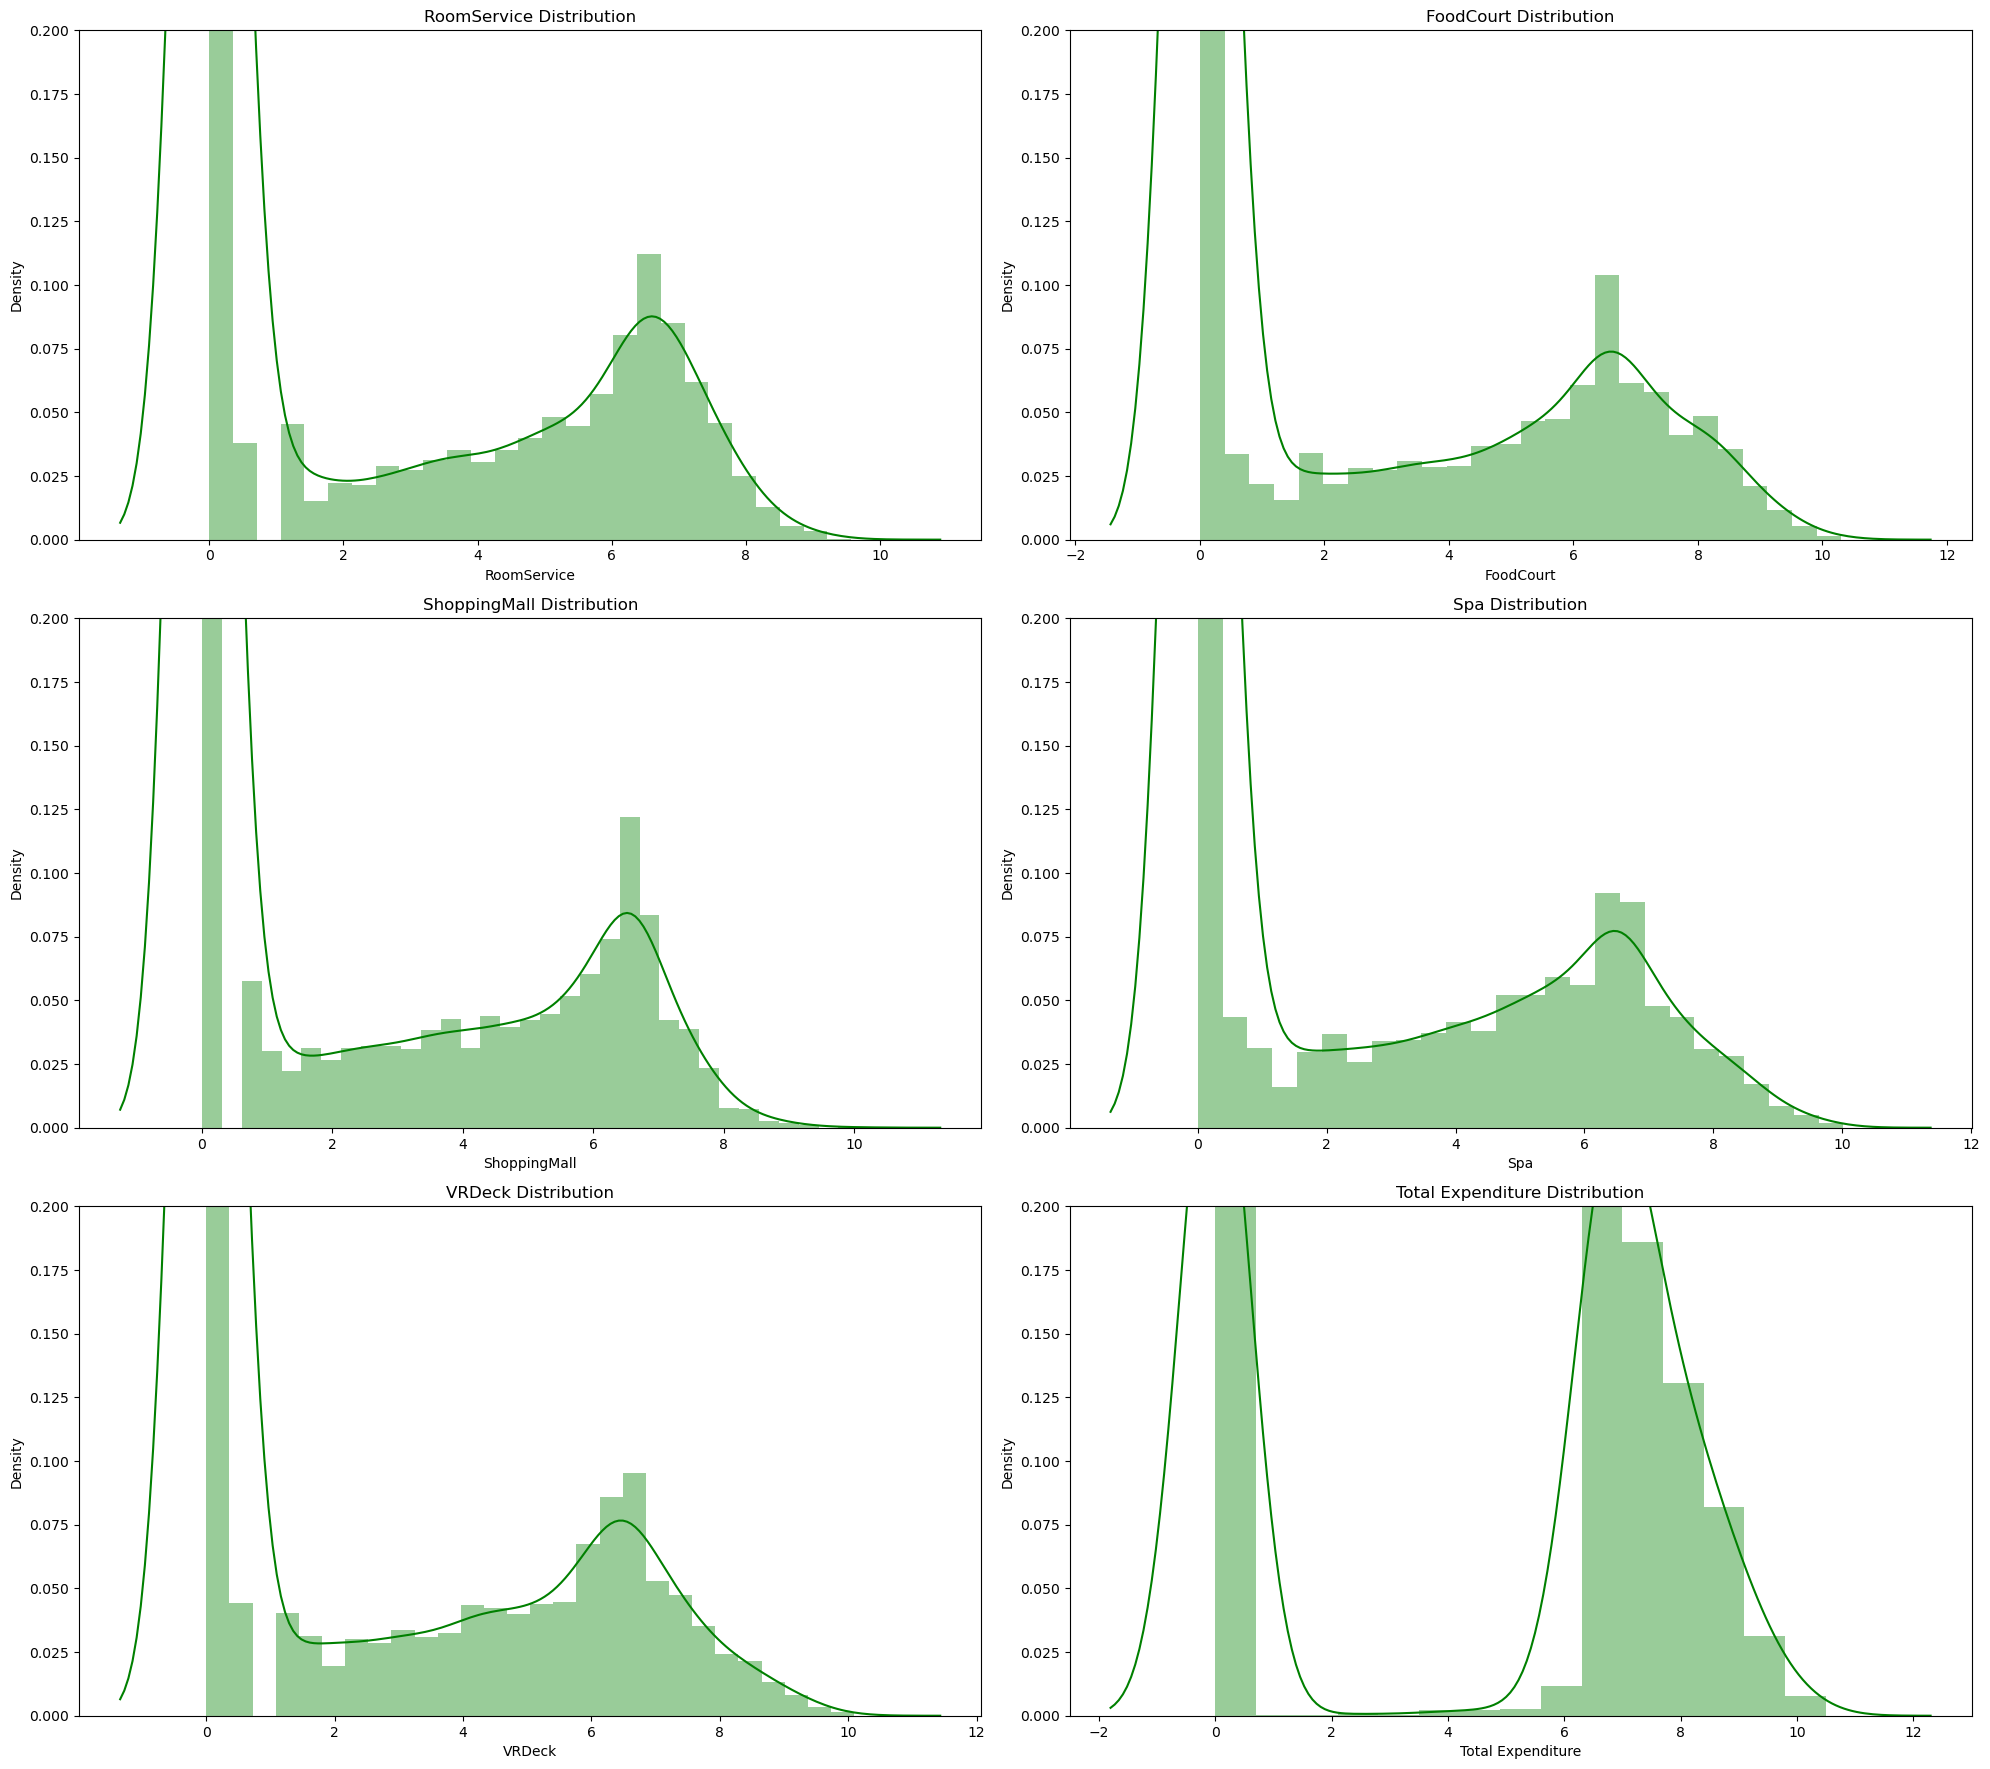

In [47]:
x=1

plt.figure(figsize=(20,35))
for i in cols:
    plt.subplot(6,2,x)
    sns.distplot(df_train[i],color="green")
    plt.ylim(0,0.2)
    plt.title(f"{i} Distribution")
    plt.tight_layout()
    x+=1

In [48]:
#Types of data types checking

df_train.dtypes

HomePlanet               object
CryoSleep                object
Destination              object
Age                     float64
VIP                      object
RoomService             float64
FoodCourt               float64
ShoppingMall            float64
Spa                     float64
VRDeck                  float64
Transported              object
Travelling_Solo          object
Group_Size              float64
Cabin_Deck               object
Cabin_Side               object
Cabin_Region1            object
Cabin_Region2            object
Cabin_Region3            object
Cabin_Region4            object
Cabin_Region5            object
Cabin_Region6            object
Age Group                object
Total Expenditure       float64
No Spending              object
Expenditure Category     object
dtype: object

Object type data which are boolean are to be converted

In [49]:
cols = ["CryoSleep","VIP","Travelling_Solo","No Spending","Cabin_Region1","Cabin_Region2","Cabin_Region3","Cabin_Region4",
       "Cabin_Region5","Cabin_Region6"]

df_train[cols] = df_train[cols].astype(bool)
df_test[cols] = df_test[cols].astype(bool)

In [50]:
#Encoding
#OneHot for nominal
#LabelEncoding for categorical data

In [51]:
nominal_cat_cols = ["HomePlanet","Destination"]
ordinal_cat_cols = ["CryoSleep","VIP","Travelling_Solo","Cabin_Deck","Cabin_Side","Cabin_Region1","Cabin_Region2",
                    "Cabin_Region3","Cabin_Region4","Cabin_Region5","Cabin_Region6","Age Group","No Spending",
                    "Expenditure Category"]

In [52]:
enc = LabelEncoder()

In [53]:
df_train[ordinal_cat_cols]=df_train[ordinal_cat_cols].apply(enc.fit_transform)
df_test[ordinal_cat_cols]=df_test[ordinal_cat_cols].apply(enc.fit_transform)

In [54]:
df_train = pd.get_dummies(df_train,columns=nominal_cat_cols)
df_test = pd.get_dummies(df_test,columns=nominal_cat_cols)

In [55]:
df_train["Transported"].replace({"False":0,"True":1},inplace=True)

In [56]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   int64  
 1   Age                        8693 non-null   float64
 2   VIP                        8693 non-null   int64  
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   Transported                8693 non-null   int64  
 9   Travelling_Solo            8693 non-null   int64  
 10  Group_Size                 8693 non-null   float64
 11  Cabin_Deck                 8693 non-null   int64  
 12  Cabin_Side                 8693 non-null   int64  
 13  Cabin_Region1              8693 non-null   int64

In [57]:
cols = ["HomePlanet_Earth","HomePlanet_Europa","HomePlanet_Mars","Destination_55 Cancri e","Destination_PSO J318.5-22","Destination_TRAPPIST-1e"]

df_train[cols] = df_train[cols].astype(int)
df_test[cols] = df_test[cols].astype(int)


In [58]:
df_train.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Travelling_Solo,Group_Size,Cabin_Deck,Cabin_Side,Cabin_Region1,Cabin_Region2,Cabin_Region3,Cabin_Region4,Cabin_Region5,Cabin_Region6,Age Group,Total Expenditure,No Spending,Expenditure Category,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,39.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,1.0,1,0,1,0,0,0,0,0,4,0.000000,1,3,0,1,0,0,0,1
1,0,24.0,0,4.700480,2.302585,3.258097,6.309918,3.806662,1,1,1.0,5,1,1,0,0,0,0,0,2,6.602588,0,2,1,0,0,0,0,1
2,0,58.0,1,3.784190,8.182280,0.000000,8.812248,3.912023,0,0,2.0,0,1,1,0,0,0,0,0,5,9.248021,0,0,0,1,0,0,0,1
3,0,33.0,0,0.000000,7.157735,5.918894,8.110728,5.267858,0,0,2.0,0,1,1,0,0,0,0,0,4,8.551981,0,0,0,1,0,0,0,1
4,0,16.0,0,5.717028,4.262680,5.023881,6.338594,1.098612,1,1,1.0,5,1,1,0,0,0,0,0,1,6.995766,0,2,1,0,0,0,0,1


In [59]:
X = df_train.drop(columns=["Transported"])
y = df_train["Transported"]

In [60]:
scaler = StandardScaler()

In [61]:
X_scaled = scaler.fit_transform(X)
test_df_scaled = scaler.fit_transform(df_test)

Splitting data which does not need scaling

In [62]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

Splitting data for model which needs scaling

In [63]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_scaled,y,test_size=0.2,random_state=0)

# Model Building for scaled data

In [64]:
training_score=[]
testing_score = []

In [65]:
def model_prediction(model):
    model.fit(x_train1,y_train1)
    x_train_pred1 = model.predict(x_train1)
    x_test_pred1 = model.predict(x_test1)
    a = accuracy_score(y_train1,x_train_pred1)*100
    b = accuracy_score(y_test1,x_test_pred1)*100
    training_score.append(a)
    testing_score.append(b)
    
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)
    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test1,x_test_pred1)
    print(cm)

In [66]:
model_prediction(LogisticRegression(random_state = 0))

Accuracy_Score of LogisticRegression(random_state=0) model on Training Data is: 77.8688524590164
Accuracy_Score of LogisticRegression(random_state=0) model on Testing Data is: 77.17078780908568

------------------------------------------------------------------------
Confusion Matrix of LogisticRegression(random_state=0) model is:
[[638 225]
 [172 704]]


In [67]:
model_prediction(KNeighborsClassifier(n_neighbors= 5,p=2, metric='minkowski'))

Accuracy_Score of KNeighborsClassifier() model on Training Data is: 83.01696865113604
Accuracy_Score of KNeighborsClassifier() model on Testing Data is: 75.50316273720529

------------------------------------------------------------------------
Confusion Matrix of KNeighborsClassifier() model is:
[[672 191]
 [235 641]]


In [68]:
model_prediction(SVC(kernel ='rbf', random_state = 0))

Accuracy_Score of SVC(random_state=0) model on Training Data is: 81.8234109864826
Accuracy_Score of SVC(random_state=0) model on Testing Data is: 79.700977573318

------------------------------------------------------------------------
Confusion Matrix of SVC(random_state=0) model is:
[[688 175]
 [178 698]]


In [69]:
model_prediction(GaussianNB())

Accuracy_Score of GaussianNB() model on Training Data is: 73.94305435720449
Accuracy_Score of GaussianNB() model on Testing Data is: 73.3755031627372

------------------------------------------------------------------------
Confusion Matrix of GaussianNB() model is:
[[698 165]
 [298 578]]


# Model Building for unscaled data

In [70]:
def model_prediction(model):
    model.fit(x_train,y_train)
    x_train_pred = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    a = accuracy_score(y_train,x_train_pred)*100
    b = accuracy_score(y_test,x_test_pred)*100
    training_score.append(a)
    testing_score.append(b)
    
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)
    print("\n------------------------------------------------------------------------")

    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test,x_test_pred)
    print(cm)

In [71]:
model_prediction(DecisionTreeClassifier(criterion = 'entropy', random_state = 0))

Accuracy_Score of DecisionTreeClassifier(criterion='entropy', random_state=0) model on Training Data is: 98.53321829163072
Accuracy_Score of DecisionTreeClassifier(criterion='entropy', random_state=0) model on Testing Data is: 74.52558941920644

------------------------------------------------------------------------
Confusion Matrix of DecisionTreeClassifier(criterion='entropy', random_state=0) model is:
[[647 216]
 [227 649]]


In [72]:
model_prediction(RandomForestClassifier())

Accuracy_Score of RandomForestClassifier() model on Training Data is: 98.53321829163072
Accuracy_Score of RandomForestClassifier() model on Testing Data is: 80.85106382978722

------------------------------------------------------------------------
Confusion Matrix of RandomForestClassifier() model is:
[[730 133]
 [200 676]]


# Comparison among models

In [73]:
models = ["Logistic Regression","KNN","SVM","Naive Bayes","Decision Tree","Random Forest"]
df = pd.DataFrame({"Algorithms":models,
                   "Training Score":training_score,
                   "Testing Score":testing_score})

In [74]:
df

,Algorithms,Training Score,Testing Score
0,Logistic Regression,77.868852,77.170788
1,KNN,83.016969,75.503163
2,SVM,81.823411,79.700978
3,Naive Bayes,73.943054,73.375503
4,Decision Tree,98.533218,74.525589
5,Random Forest,98.533218,80.851064


In [75]:
#We can clearly see Random Forest have best fit

# Predicting Test Data

In [76]:
classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)
pred = classifier.predict(df_test)

In [77]:
pred

array([0, 0, 1, ..., 1, 1, 0])

In [78]:
pass_id.head()

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01


In [79]:
pass_id["Transported"] = pred

In [80]:
pass_id.shape

(4277, 2)

In [81]:
pass_id.to_csv("titanic_spaceship.csv",index=False)